<a id="index">Index</a>

1. [Encoding and Transformation](#Encoding-and-Transformation)
2. [Grid Search](#Grid-Search)
3. [Scores](#Scores)
4. [Final Predictions for 2nd FY](#Final-Predictions-for-2nd-FY)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import MinMaxScaler, StandardScaler
mmScaler = MinMaxScaler()
stdScaler = StandardScaler()


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.pipeline import make_pipeline


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,\
                            recall_score, precision_score, plot_roc_curve,\
                            precision_recall_curve, plot_precision_recall_curve


import re, os

from itertools import product

import pickle, json


DEFAULT_RANDOM_STATE = 786

In [2]:
def plotConfusionMatrix(estimator, x, y_true):
    check_preds = estimator.predict(x)

    cm = confusion_matrix(y_true, check_preds)
    plt.rcParams["font.size"] = 10
    cm_display = ConfusionMatrixDisplay(cm).plot()

    plt.xticks(ticks=[0,1], labels=["Active", "Resigned"])
    plt.yticks(ticks=[0,1], labels=["Active", "Resigned"])
    plt.show()

    roc    = roc_auc_score(y_true, check_preds)
    recall = recall_score(y_true, check_preds)
    preci  = precision_score(y_true, check_preds)
    acc    = accuracy_score(y_true, check_preds)

    print(f"{'ROC':<11}: {roc:.4f}\n{'Recall':<11}: {recall:.4f}\n{'Precision':<11}: {preci:.4f}\n{'Accuracy':<11}: {acc:.4f}")

In [3]:
def threshold_score(estimator, x_data, y_true, threshold = 0.5):
    check_preds = estimator.predict_proba(x_data)[:, 0]
    check_preds = (check_preds < threshold).astype(int)

    cm = confusion_matrix(y_true, check_preds)
    plt.rcParams["font.size"] = 10
    cm_display = ConfusionMatrixDisplay(cm).plot()

    plt.xticks(ticks=[0,1], labels=["Active", "Resigned"])
    plt.yticks(ticks=[0,1], labels=["Active", "Resigned"])
    plt.show()

    roc    = roc_auc_score(y_true, check_preds)
    recall = recall_score(y_true, check_preds)
    preci  = precision_score(y_true, check_preds)
    acc    = accuracy_score(y_true, check_preds)

    print(f"{'ROC':<11}: {roc:.4f}\n{'Recall':<11}: {recall:.4f}\n{'Precision':<11}: {preci:.4f}\n{'Accuracy':<11}: {acc:.4f}")

In [4]:
def saveModelData(model, prefix, gridcv_obj=None, comments=None, inFolder="Models/"):
    model_file = inFolder.strip("/\\")+"/"+prefix+".pkl"
    info_file  = inFolder.strip("/\\")+"/"+prefix+".txt"
    
    if os.path.exists(model_file):
        prompt = "hjwbj234j"
        while(not prompt.lower() in ["y", "n"]):
            prompt = input(f"{model_file} exists, overwrite?[y/n] ")
        if(prompt=="n"):
            print("\nAborted.")
            return
    
    pickle.dump(model, open(model_file, "wb"))
    
    if os.path.exists(info_file):
        prompt = "hjwbj234j"
        while(not prompt.lower() in ["y", "n"]):
            prompt = input(f"{info_file} exists, overwrite?[y/n] ")
        if(prompt=="n"):
            print("\nAborted.")
            return
    
    with open(info_file, "w") as f:
        model_info = json.dumps(model.get_params(), indent=4)
        f.write("""Model Params:\n\n""")
        f.write(model_info)
        if(not gridcv_obj is None):
            f.write("""\n\nGridSearchCV Params:\n\n""")
            grid_search_info = json.dumps(gridcv_obj.get_params(), indent=4, default=str)
            f.write(grid_search_info)
        f.write("""\n\nComments:\n\n""")
        f.write(str(comments))

In [5]:
df = pd.read_csv("Final_for_model.csv")
df.head()

,Employee No,Employee Name,Gender,Leaving Reason,Previous Employer,Latest Available Rating,Profit Center,Employee Location,People Group,Employee Category,Supervisor name,Month of termination,Tenure_till_18,Tenure_till_18_in_months,Tenure_till_18_in_years,Age_16_18,Current Status16_18,Is promoted,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,BD Hours,NC Hours,Utilization%,Utilization Status,Utilization%-Mean
0,1,Rochette Jilleen,Unknown,Unknown,Unknown,Unknown,PC - 1,Location 3,Client Service Staff,SVP/VP,Idalina Lauraine,Unknown,17.497964,209.975564,17.0,0.0,Active,Yes,4168.0,3666.5,1084.0,404.0,97.5,2623.5,74.0,29.661004,Below Avg,29.661004
1,2,Daryl Natalina,Unknown,Unknown,Unknown,Unknown,PC - 2,Location 7,Client Service Staff,SVP/VP,Idalina Lauraine,Unknown,18.834062,226.008748,19.0,0.0,Active,No,4168.0,3750.0,1277.5,364.0,54.0,1294.5,1330.5,34.083718,Below Avg,34.083718
2,3,Annnora Gabrielle,Unknown,Unknown,Unknown,Unknown,PC - 2,Location 7,Client Service Staff,SVP/VP,Idalina Lauraine,Unknown,17.161201,205.934413,17.0,0.0,Active,No,4168.0,3618.5,2177.5,482.0,67.5,970.5,907.0,60.553933,Above Avg,60.553933
3,4,Barbee Joey,M,Career Growth,kadoo,Unknown,PC - 3,Location 1,Client Service Staff,Awaiting Termination,Idalina Lauraine,2,17.413089,208.957063,17.0,43.0,Resigned,No,3928.0,3491.5,546.0,404.0,32.5,2743.0,279.0,15.695026,Low,15.695026
4,5,Idalina Lauraine,Unknown,Unknown,Unknown,Unknown,PC - 4,Location 3,Client Service Staff,Level 1/2,Abagail Druci,Unknown,18.751925,225.023101,19.0,0.0,Active,No,1312.0,1205.0,149.0,104.0,3.0,1159.0,818.0,12.365145,Low,12.365145


In [6]:
drop_cols = [
    "Employee No"
    , "Employee Name"
    , "Previous Employer"
    , "People Group"
    , "Employee Category"
    , "Supervisor name"
    , "Tenure_till_18_in_months"
    , "Tenure_till_18_in_years"
    , "Utilization Status"
    , "Employee Location"
    , "Gender"
    , "Leaving Reason"
    , "Latest  Available Rating"
    , "Tenure_till_18"
    , "Age_16_18"
    , "BD Hours"
    , "Month of termination"
]

provisional_cols = [
    "dummy"
#     , "Utilization%"
    , "Utilization%-Mean"
#     , 'Total Available Hours'
#     , 'Total Hours'
#     , 'Work Hours'
#     , 'Leave Hours'
]

data = df.drop(drop_cols + provisional_cols[1:], axis=1)
data.head()

,Profit Center,Current Status16_18,Is promoted,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,NC Hours,Utilization%
0,PC - 1,Active,Yes,4168.0,3666.5,1084.0,404.0,97.5,74.0,29.661004
1,PC - 2,Active,No,4168.0,3750.0,1277.5,364.0,54.0,1330.5,34.083718
2,PC - 2,Active,No,4168.0,3618.5,2177.5,482.0,67.5,907.0,60.553933
3,PC - 3,Resigned,No,3928.0,3491.5,546.0,404.0,32.5,279.0,15.695026
4,PC - 4,Active,No,1312.0,1205.0,149.0,104.0,3.0,818.0,12.365145


## [Encoding and Transformation](#index)

1. Resigned and Active are mapped to 1 and 0 respectively
2. Log Transformation is applied to `NC Hours` and `Leave Hours`, and power transformation to `Utilization%` (power = 1.3)

In [7]:
def profitCenterClub(row):
    pcnum = int(row["Profit Center"].split()[-1])
    
    if pcnum>3:
        return "Other"
    
    return row["Profit Center"]

data["ProfitCenter"] = data.apply(profitCenterClub, axis=1)
data.drop(["Profit Center"], axis=1, inplace=True)


### Splitting data into x(predictors) and y(target)
data_x = pd.get_dummies(data.drop(["Current Status16_18"], axis=1))
data_y = data["Current Status16_18"].map({"Active" : 0, "Resigned" : 1})



def logTrans(data, cols):
    for col in cols:
        data[col] = np.log(data[col]+1)

transform_cols = ["NC Hours", "Leave Hours"]
logTrans(data_x, transform_cols)


### Transforming the utilization% column using the below power based on the resulting distribution in EDA
util_transform_power = 1.3
data_x["Utilization%"] = data_x["Utilization%"].transform(lambda s: s**(1/util_transform_power))
data_x.head()

,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,NC Hours,Utilization%,Is promoted_No,Is promoted_Yes,ProfitCenter_Other,ProfitCenter_PC - 1,ProfitCenter_PC - 2,ProfitCenter_PC - 3
0,4168.0,3666.5,1084.0,6.003887,97.5,4.317488,13.565964,0,1,0,1,0,0
1,4168.0,3750.0,1277.5,5.899897,54.0,7.194061,15.096709,1,0,0,0,1,0
2,4168.0,3618.5,2177.5,6.180017,67.5,6.811244,23.489769,1,0,0,0,1,0
3,3928.0,3491.5,546.0,6.003887,32.5,5.634790,8.314133,1,0,0,0,0,1
4,1312.0,1205.0,149.0,4.653960,3.0,6.708084,6.920751,1,0,1,0,0,0


In [8]:
data_x["Utilization%"].skew(), data_x["Utilization%"].kurtosis()

(-0.003100560484439175, 12.536384371340938)

In [9]:
def scaleTheSplit(train_data, test_data, scaler, transform_train = False):
    scaler.fit(train_data)
    return_test  = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)
    
    if transform_train:
        return_train = pd.DataFrame(scaler.transform(train_data), columns=train_data.columns)
        return return_train, return_test

    return train_data, return_test

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2,
                                                    stratify=data_y,
                                                    random_state=DEFAULT_RANDOM_STATE)
x_train_scaled, x_test = scaleTheSplit(x_train, x_test, mmScaler, transform_train=True)

In [11]:
y_test.value_counts(normalize=True), y_train.value_counts(normalize=True)

(0    0.743243
 1    0.256757
 Name: Current Status16_18, dtype: float64,
 0    0.74605
 1    0.25395
 Name: Current Status16_18, dtype: float64)

## [Grid Search](#index)

In [12]:
model3 = RandomForestClassifier(random_state = DEFAULT_RANDOM_STATE, n_jobs = 3)
rf_params = {
    'n_estimators': range(100, 201, 50),
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
#     'max_depth': [4, 5, 6, 7, 8, 9],
    "class_weight": [{0: wt} for wt in np.linspace(0.1, 0.4, 5)],
    "min_samples_split": [2, 3, 4]
}
rf_gridcv = GridSearchCV(estimator = model3,
                         param_grid = rf_params,
                         cv = 5,
                         scoring = ["accuracy", "recall", "precision", "f1"],
                         refit = "f1",
                         return_train_score = True,
                         verbose = 1)
rf_gridcv.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=3, random_state=786),
             param_grid={'class_weight': [{0: 0.1}, {0: 0.17500000000000002},
                                          {0: 0.25}, {0: 0.32500000000000007},
                                          {0: 0.4}],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': range(100, 201, 50)},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'recall', 'precision', 'f1'], verbose=1)

In [13]:
rf_gridcv.cv_results_["mean_test_f1"].min(),\
rf_gridcv.cv_results_["mean_test_f1"].max(),\
rf_gridcv.cv_results_["mean_test_f1"].std()

(0.6491844126443282, 0.6939980789933409, 0.009292957014849878)

In [14]:
rf_gridcv.best_params_

{'class_weight': {0: 0.25},
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 100}

## [Scores](#index)

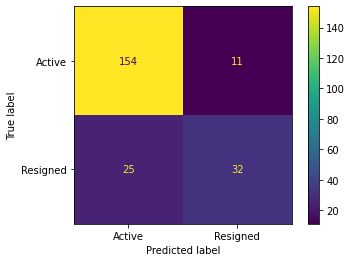

ROC        : 0.7474
Recall     : 0.5614
Precision  : 0.7442
Accuracy   : 0.8378


In [15]:
plotConfusionMatrix(rf_gridcv, x_test, y_test)

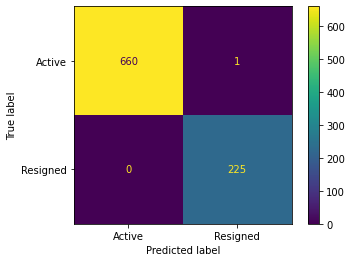

ROC        : 0.9992
Recall     : 1.0000
Precision  : 0.9956
Accuracy   : 0.9989


In [16]:
threshold_score(rf_gridcv, x_train_scaled, y_train)

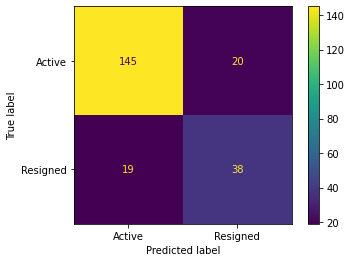

ROC        : 0.7727
Recall     : 0.6667
Precision  : 0.6552
Accuracy   : 0.8243


In [17]:
threshold_score(rf_gridcv, x_test, y_test, 0.6243)

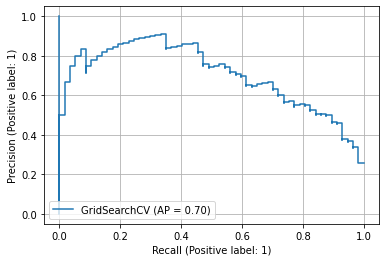

In [18]:
plot_precision_recall_curve(rf_gridcv, x_test, y_test)
plt.grid()

In [20]:
comments = f"""\
Grid search was done on splitted (random_state = {DEFAULT_RANDOM_STATE}) and scaled train data. Then the best estimator from the grid search was 
evaluated on the test data (completely untouched and scaled using the train fit).

Utilization% transformation power = 1.3

Threshold 0.6525

ROC        : 0.7812
Recall     : 0.7018
Precision  : 0.6349
Accuracy   : 0.8198
"""
saveModelData(rf_gridcv.best_estimator_, "rf#1", rf_gridcv, comments, "Saved Models")

Saved Models/rf#1.pkl exists, overwrite?[y/n] y
Saved Models/rf#1.txt exists, overwrite?[y/n] y


## [Final Predictions for 2nd FY](#index)

In [21]:
year2 = pd.read_excel("Data - working\staff utlz latest 17-18_masked.xlsx", skiprows=1)

In [22]:
target_employees = year2["Employee No"]

In [23]:
target_data = df[df["Employee No"].isin(target_employees)]

In [24]:
employee_no = target_data["Employee No"].copy()
promoted    = target_data["Is promoted"].copy()

In [25]:
drop_cols = [
    "Employee No"
    , "Employee Name"
    , "Previous Employer"
    , "People Group"
    , "Employee Category"
    , "Supervisor name"
    , "Tenure_till_18_in_months"
    , "Tenure_till_18_in_years"
    , "Utilization Status"
    , "Employee Location"
    , "Gender"
    , "Leaving Reason"
    , "Latest  Available Rating"
    , "Tenure_till_18"
    , "Age_16_18"
    , "BD Hours"
    , "Month of termination"
]

provisional_cols = [
    "dummy"
#     , "Utilization%"
    , "Utilization%-Mean"
#     , 'Total Available Hours'
#     , 'Total Hours'
#     , 'Work Hours'
#     , 'Leave Hours'
]

target_data = target_data.drop(drop_cols + provisional_cols[1:], axis=1)
target_data.head()

,Profit Center,Current Status16_18,Is promoted,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,NC Hours,Utilization%
0,PC - 1,Active,Yes,4168.0,3666.5,1084.0,404.0,97.5,74.0,29.661004
1,PC - 2,Active,No,4168.0,3750.0,1277.5,364.0,54.0,1330.5,34.083718
2,PC - 2,Active,No,4168.0,3618.5,2177.5,482.0,67.5,907.0,60.553933
3,PC - 3,Resigned,No,3928.0,3491.5,546.0,404.0,32.5,279.0,15.695026
5,PC - 1,Active,No,4168.0,3635.0,899.0,520.0,13.0,731.0,24.728421


In [26]:
target_data.drop(["Current Status16_18"], axis=1, inplace=True)

In [27]:
def profitCenterClub(row):
    pcnum = int(row["Profit Center"].split()[-1])
    
    if pcnum>3:
        return "Other"
    
    return row["Profit Center"]

target_data["ProfitCenter"] = target_data.apply(profitCenterClub, axis=1)
target_data.drop(["Profit Center"], axis=1, inplace=True)



def logTrans(data, cols):
    for col in cols:
        data[col] = np.log(data[col]+1)

transform_cols = ["NC Hours", "Leave Hours"]
logTrans(target_data, transform_cols)


### Transforming the utilization% column using the below power based on the resulting distribution in EDA
util_transform_power = 1.3
target_data["Utilization%"] = target_data["Utilization%"].transform(lambda s: s**(1/util_transform_power))
target_data.head()

,Is promoted,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,NC Hours,Utilization%,ProfitCenter
0,Yes,4168.0,3666.5,1084.0,6.003887,97.5,4.317488,13.565964,PC - 1
1,No,4168.0,3750.0,1277.5,5.899897,54.0,7.194061,15.096709,PC - 2
2,No,4168.0,3618.5,2177.5,6.180017,67.5,6.811244,23.489769,PC - 2
3,No,3928.0,3491.5,546.0,6.003887,32.5,5.634790,8.314133,PC - 3
5,No,4168.0,3635.0,899.0,6.255750,13.0,6.595781,11.794771,PC - 1


In [28]:
target_data = pd.get_dummies(target_data)
target_data = pd.DataFrame(mmScaler.transform(target_data), columns=target_data.columns)
target_data.head()

,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,NC Hours,Utilization%,Is promoted_No,Is promoted_Yes,ProfitCenter_Other,ProfitCenter_PC - 1,ProfitCenter_PC - 2,ProfitCenter_PC - 3
0,1.000000,0.879679,0.229856,0.755561,0.390782,0.524465,0.098949,0.0,1.0,0.0,1.0,0.0,0.0
1,1.000000,0.899712,0.270886,0.742474,0.216433,0.873896,0.110114,1.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,0.868162,0.461726,0.777726,0.270541,0.827393,0.171332,1.0,0.0,0.0,0.0,1.0,0.0
3,0.942418,0.837692,0.115776,0.755561,0.130261,0.684484,0.060643,1.0,0.0,0.0,0.0,0.0,1.0
4,1.000000,0.872121,0.190628,0.787257,0.052104,0.801220,0.086030,1.0,0.0,0.0,1.0,0.0,0.0


### Best parameters chosen from grid search

In [30]:
year2names = year2[["Employee No", "Employee Name"]].copy()

In [31]:
preds = pd.DataFrame({"Employee No": employee_no, "Prediction": rf_gridcv.predict(target_data), "Is promoted": promoted})
preds = pd.merge(preds, year2names, on="Employee No")
# preds = preds[["Employee Name", "Prediction"]]

resignations = preds[preds["Prediction"]==1]

In [32]:
resignations.head()

,Employee No,Prediction,Is promoted,Employee Name
14,19,1,No,Cordey Sofia
38,45,1,No,Jenny Kasey
43,50,1,No,Leta Evangeline
54,66,1,No,Leela Jsandye
62,75,1,No,Norene Ethelyn


In [33]:
resignations.shape

(136, 4)

In [34]:
resignations["Is promoted"].value_counts()

No    136
Name: Is promoted, dtype: int64